---
title: "EDA Reddit"
format:
  html: 
    self-contained: true
---

# Initialize spark session

In [ ]:
# setup - Run only once per Kernel App
%conda install https://anaconda.org/conda-forge/openjdk/11.0.1/download/linux-64/openjdk-11.0.1-hacce0ff_1021.tar.bz2

# install PySpark
%pip install pyspark==3.4.0

# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

In [7]:
# import pyspark and build Spark session
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder.appName("PySparkApp")
    .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.2.2")
    .config(
        "fs.s3a.aws.credentials.provider",
        "com.amazonaws.auth.ContainerCredentialsProvider",
    )
    .getOrCreate()
)

print(spark.version)

3.4.0


# Disable Output Cell Folding

In [8]:
# disable output cell folding
from IPython.core.display import display, HTML
display(HTML("<style>div.jp-OutputArea-output pre {white-space: pre;}</style>"))

/tmp/ipykernel_201/4063854407.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import display, HTML


# Read in the Data

In [9]:
import sagemaker
session = sagemaker.Session()
bucket = session.default_bucket()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [10]:
# set up S3 paths
aita_path = f"s3a://{bucket}/BDproject/aita.parquet"
aio_path = f"s3a://{bucket}/BDproject/aio.parquet"
ask_reddit_path = f"s3a://{bucket}/BDproject/ask_reddit.parquet"
posts_path = f"s3a://{bucket}/BDproject/posts.parquet"

# read the Parquet files from S3
aita_df = spark.read.parquet(aita_path)
aio_df = spark.read.parquet(aio_path)
ask_reddit_df = spark.read.parquet(ask_reddit_path)
posts_df = spark.read.parquet(posts_path)


# show headers with 5 rows for each DataFrame
print("AITA DataFrame")
aita_df.show(5)

print("AIO DataFrame")
aio_df.show(5)

print("Ask Reddit DataFrame")
ask_reddit_df.show(5)

print("Posts DataFrame")
posts_df.show(5)

24/11/14 00:28:45 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


AITA DataFrame


+-------+-------------------+----------------+--------------+--------------------+--------------------+----------+------------+-------+-------------------+----------+------------------+-------+---------+-------------------+-----------------+--------------------+-------------+------+----------------+-----------------+--------------------+---------------+
|post_id|        post_author|created_utc_post|subreddit_post|          post_title|            selftext|score_post|num_comments|over_18|  created_date_post|comment_id|    comment_author|link_id|parent_id|created_utc_comment|subreddit_comment|        comment_body|score_comment|gilded|controversiality|top_level_comment|created_date_comment|time_since_post|
+-------+-------------------+----------------+--------------+--------------------+--------------------+----------+------------+-------+-------------------+----------+------------------+-------+---------+-------------------+-----------------+--------------------+-------------+------+-----

+-------+--------------------+----------------+---------------+--------------------+--------------------+----------+------------+-------+-------------------+----------+------------------+-------+---------+-------------------+-----------------+--------------------+-------------+------+----------------+-----------------+--------------------+---------------+
|post_id|         post_author|created_utc_post| subreddit_post|          post_title|            selftext|score_post|num_comments|over_18|  created_date_post|comment_id|    comment_author|link_id|parent_id|created_utc_comment|subreddit_comment|        comment_body|score_comment|gilded|controversiality|top_level_comment|created_date_comment|time_since_post|
+-------+--------------------+----------------+---------------+--------------------+--------------------+----------+------------+-------+-------------------+----------+------------------+-------+---------+-------------------+-----------------+--------------------+-------------+------

+-------+-----------+----------------+--------------+--------------------+---------+----------+------------+-------+-------------------+----------+-------------------+-------+---------+-------------------+-----------------+--------------------+-------------+------+----------------+-----------------+--------------------+---------------+
|post_id|post_author|created_utc_post|subreddit_post|          post_title| selftext|score_post|num_comments|over_18|  created_date_post|comment_id|     comment_author|link_id|parent_id|created_utc_comment|subreddit_comment|        comment_body|score_comment|gilded|controversiality|top_level_comment|created_date_comment|time_since_post|
+-------+-----------+----------------+--------------+--------------------+---------+----------+------------+-------+-------------------+----------+-------------------+-------+---------+-------------------+-----------------+--------------------+-------------+------+----------------+-----------------+--------------------+---

# Date Range

In [23]:
# get the minimum and maximum dates from your data
date_range = posts_df.agg(
    F.min("created_date_post").alias("min_date"),
    F.max("created_date_post").alias("max_date")
).collect()

# display the date range
min_date = date_range[0]["min_date"]
max_date = date_range[0]["max_date"]
print(f"Data range: {min_date} to {max_date}")

Data range: 2023-06-01 00:03:43 to 2024-07-31 23:55:28


In [25]:
# group by subreddit and get the minimum and maximum dates
date_range_by_subreddit = posts_df.groupBy("subreddit_post").agg(
    F.min("created_date_post").alias("min_date"),
    F.max("created_date_post").alias("max_date")
)

# show results
date_range_by_subreddit.show()

+---------------+-------------------+-------------------+
| subreddit_post|           min_date|           max_date|
+---------------+-------------------+-------------------+
|AmIOverreacting|2023-11-10 11:42:50|2024-07-31 23:52:46|
|  AmItheAsshole|2023-06-01 00:03:43|2024-07-31 23:50:48|
|      AskReddit|2023-06-01 00:10:58|2024-07-31 23:55:28|
+---------------+-------------------+-------------------+



# Creating a new variable - viral
so far, we have created two new variables: 1) top_level_comment - a binary variable indiciating if the comment is a direct response to the post and 2) time_since_post - time (hr) difference between initial post and comment. <br></br>
Let's create a new variable in posts_df that indicates if a post reached the front page of reddit (or if it went viral). We will accomplish this using score_post and num_comments. Let's take a further look at each variable.

In [16]:
from pyspark.sql import functions as F

# group by subreddit and calculate statistics
stats_by_subreddit = posts_df.groupBy("subreddit_post").agg(
    F.count("score_post").alias("count"),
    F.mean("score_post").alias("mean_score"),
    F.stddev("score_post").alias("stddev_score"),
    F.min("score_post").alias("min_score"),
    F.max("score_post").alias("max_score"),
    F.expr("percentile_approx(score_post, 0.25)").alias("25th_percentile_score"),
    F.expr("percentile_approx(score_post, 0.5)").alias("median_score"),
    F.expr("percentile_approx(score_post, 0.75)").alias("75th_percentile_score"),
    F.expr("percentile_approx(score_post, 0.9)").alias("90th_percentile_score"),
    F.expr("percentile_approx(score_post, 0.95)").alias("95th_percentile_score"),
    F.count("num_comments").alias("count_comments"),
    F.mean("num_comments").alias("mean_comments"),
    F.stddev("num_comments").alias("stddev_comments"),
    F.min("num_comments").alias("min_comments"),
    F.max("num_comments").alias("max_comments"),
    F.expr("percentile_approx(num_comments, 0.25)").alias("25th_percentile_comments"),
    F.expr("percentile_approx(num_comments, 0.5)").alias("median_comments"),
    F.expr("percentile_approx(num_comments, 0.75)").alias("75th_percentile_comments"),
    F.expr("percentile_approx(num_comments, 0.9)").alias("90th_percentile_comments"),
    F.expr("percentile_approx(num_comments, 0.95)").alias("95th_percentile_comments")
)

# show the results
stats_by_subreddit.show(truncate=False)

+---------------+-----+-----------------+------------------+---------+---------+---------------------+------------+---------------------+---------------------+---------------------+--------------+------------------+------------------+------------+------------+------------------------+---------------+------------------------+------------------------+------------------------+
|subreddit_post |count|mean_score       |stddev_score      |min_score|max_score|25th_percentile_score|median_score|75th_percentile_score|90th_percentile_score|95th_percentile_score|count_comments|mean_comments     |stddev_comments   |min_comments|max_comments|25th_percentile_comments|median_comments|75th_percentile_comments|90th_percentile_comments|95th_percentile_comments|
+---------------+-----+-----------------+------------------+---------+---------+---------------------+------------+---------------------+---------------------+---------------------+--------------+------------------+------------------+------------

Since some subreddits are inherently more popular and posts from these subreddits are more likely to reach the front page of Reddit, it may make more sense to define “viral” posts using an overall threshold across all subreddits instead of individual thresholds for each subreddit.

In [17]:
# calculate 90th percentile thresholds for the entire dataset
overall_thresholds = posts_df.agg(
    F.expr("percentile_approx(score_post, 0.9)").alias("score_90th_percentile"),
    F.expr("percentile_approx(num_comments, 0.9)").alias("comments_90th_percentile")
).collect()[0]

# extract threshold values
score_90th = overall_thresholds["score_90th_percentile"]
comments_90th = overall_thresholds["comments_90th_percentile"]

# add a new column indicating if the post is viral based on overall thresholds
posts_df = posts_df.withColumn(
    "viral",
    F.when(
        (F.col("score_post") >= score_90th) &
        (F.col("num_comments") >= comments_90th),
        1
    ).otherwise(0)
)

# show the resulting DataFrame
posts_df.show(10)

+-------+--------------------+----------------+--------------+--------------------+--------------------+----------+------------+-------+-------------------+-----+
|post_id|         post_author|created_utc_post|subreddit_post|          post_title|            selftext|score_post|num_comments|over_18|  created_date_post|viral|
+-------+--------------------+----------------+--------------+--------------------+--------------------+----------+------------+-------+-------------------+-----+
|1aoclla| BrokenFamilyParents|      1707670664| AmItheAsshole|AITA for Expectin...|Obviously throwaw...|        66|          36|  false|2024-02-11 16:57:44|    0|
|1aocwzj|          apopDragon|      1707671441| AmItheAsshole|AITA for trying t...|This post will be...|         6|          43|  false|2024-02-11 17:10:41|    0|
|1aod4mf|      dorkenthusiast|      1707671995| AmItheAsshole|WIBTA for Going t...|My brother is in ...|       119|          55|  false|2024-02-11 17:19:55|    0|
|1aodioz| Environmenta

In [22]:
# calculate the count of viral posts and the total number of posts per subreddit
viral_posts_stats = posts_df.groupBy("subreddit_post").agg(
    F.sum("viral").alias("viral_posts_count"),
    F.count("*").alias("total_posts")
)

# calculate the percentage of posts that are viral
viral_posts_stats = viral_posts_stats.withColumn(
    "viral_posts_percentage",
    F.round((F.col("viral_posts_count") / F.col("total_posts")) * 100, 3)
)

# show the result
viral_posts_stats.select("subreddit_post", "viral_posts_count", "total_posts", "viral_posts_percentage").show()

+---------------+-----------------+-----------+----------------------+
| subreddit_post|viral_posts_count|total_posts|viral_posts_percentage|
+---------------+-----------------+-----------+----------------------+
|  AmItheAsshole|             1434|      33836|                 4.238|
|AmIOverreacting|               95|       3470|                 2.738|
|      AskReddit|             3274|      42296|                 7.741|
+---------------+-----------------+-----------+----------------------+



In [24]:
# membership data as of Nov 13, 2024
membership_data = [
    ("AmItheAsshole", 21946374),
    ("AskReddit", 49108885),
    ("AmIOverreacting", 615668)
]

columns = ["subreddit_post", "members"]
membership_df = spark.createDataFrame(membership_data, columns)

# join the membership data with the summary table
summary_with_membership = viral_posts_stats.join(
    membership_df,
    on="subreddit_post",
    how="left"
)

# show the updated summary table
summary_with_membership.select(
    "subreddit_post", "viral_posts_count", "total_posts", "viral_posts_percentage", "members"
).show()

+---------------+-----------------+-----------+----------------------+--------+
| subreddit_post|viral_posts_count|total_posts|viral_posts_percentage| members|
+---------------+-----------------+-----------+----------------------+--------+
|  AmItheAsshole|             1434|      33836|                 4.238|21946374|
|AmIOverreacting|               95|       3470|                 2.738|  615668|
|      AskReddit|             3274|      42296|                 7.741|49108885|
+---------------+-----------------+-----------+----------------------+--------+



## Summary Table #1

In [35]:
# add a new column for viral posts per member (scaled by 10,000 for better interpretability)
normalized_stats = summary_with_membership.withColumn(
    "viral_posts_per_10k_members",
    F.round((F.col("viral_posts_count") / F.col("members")) * 10000, 3)  # scaled by 10,000 for better readability
)

# rename 'subreddit_post' to 'subreddit'
normalized_stats = normalized_stats.withColumnRenamed("subreddit_post", "subreddit")

# rename 'viral_posts_count' to 'viral_posts'
normalized_stats = normalized_stats.withColumnRenamed("viral_posts_count", "viral_posts")

# show the results
normalized_stats.select(
    "subreddit", 
    "members", 
    "total_posts", 
    "viral_posts", 
    "viral_posts_percentage", 
    "viral_posts_per_10k_members"
).show()

+---------------+--------+-----------+-----------+----------------------+---------------------------+
|      subreddit| members|total_posts|viral_posts|viral_posts_percentage|viral_posts_per_10k_members|
+---------------+--------+-----------+-----------+----------------------+---------------------------+
|  AmItheAsshole|21946374|      33836|       1434|                 4.238|                      0.653|
|AmIOverreacting|  615668|       3470|         95|                 2.738|                      1.543|
|      AskReddit|49108885|      42296|       3274|                 7.741|                      0.667|
+---------------+--------+-----------+-----------+----------------------+---------------------------+



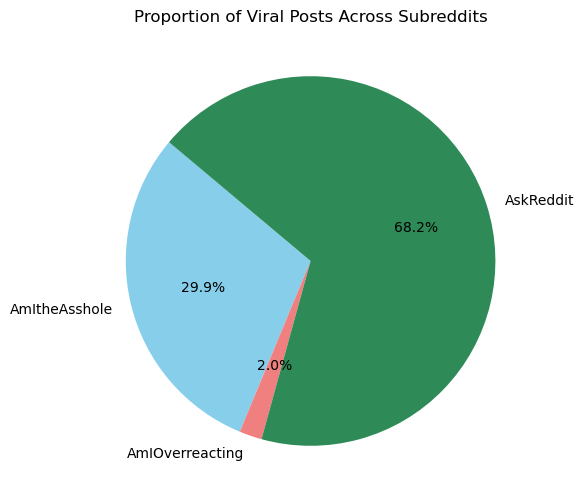

In [39]:
# convert the PySpark DataFrame to Pandas
pandas_df = normalized_stats.select("subreddit", "viral_posts").toPandas()

# create a pie chart using Matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.pie(
    pandas_df['viral_posts'], 
    labels=pandas_df['subreddit'], 
    autopct='%1.1f%%', 
    startangle=140, 
    colors=['skyblue', 'lightcoral', 'seagreen']
)
plt.title('Proportion of Viral Posts Across Subreddits')
plt.show()

# Number of Posts per day

In [40]:
# extract date from the datetime column and aggregate the number of posts per day for each subreddit
posts_per_day = posts_df.withColumn("post_date", F.to_date("created_date_post")).groupBy(
    "subreddit_post", "post_date"
).agg(F.count("*").alias("num_posts")).orderBy("post_date")

# convert to Pandas DataFrame for plotting
posts_per_day_pd = posts_per_day.toPandas()

posts_per_day_pd.head()

,subreddit_post,post_date,num_posts
0,AmItheAsshole,2023-06-01,165
1,AskReddit,2023-06-01,107
2,AmItheAsshole,2023-06-02,172
3,AskReddit,2023-06-02,133
4,AmItheAsshole,2023-06-03,131


In [44]:
!pip install seaborn
!pip install pandas

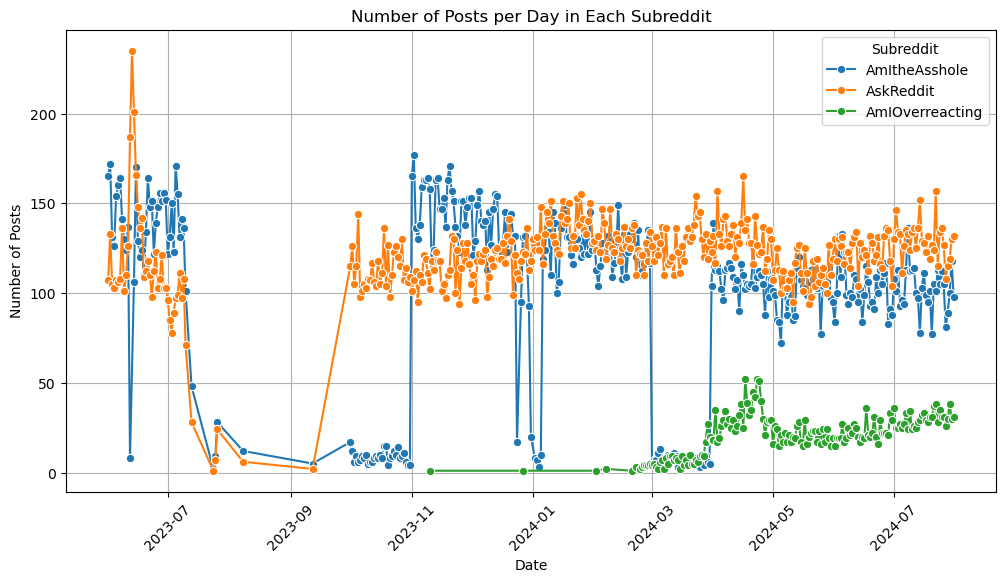

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# convert post_date to datetime format
posts_per_day_pd['post_date'] = pd.to_datetime(posts_per_day_pd['post_date'])

# plot
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=posts_per_day_pd, 
    x="post_date", 
    y="num_posts", 
    hue="subreddit_post", 
    marker="o"
)
plt.title('Number of Posts per Day in Each Subreddit')
plt.xlabel('Date')
plt.ylabel('Number of Posts')
plt.xticks(rotation=45)
plt.legend(title='Subreddit')
plt.grid(visible=True)
plt.show()

In [47]:
posts_df.show(10)

+-------+--------------------+----------------+--------------+--------------------+--------------------+----------+------------+-------+-------------------+-----+
|post_id|         post_author|created_utc_post|subreddit_post|          post_title|            selftext|score_post|num_comments|over_18|  created_date_post|viral|
+-------+--------------------+----------------+--------------+--------------------+--------------------+----------+------------+-------+-------------------+-----+
|1aoclla| BrokenFamilyParents|      1707670664| AmItheAsshole|AITA for Expectin...|Obviously throwaw...|        66|          36|  false|2024-02-11 16:57:44|    0|
|1aocwzj|          apopDragon|      1707671441| AmItheAsshole|AITA for trying t...|This post will be...|         6|          43|  false|2024-02-11 17:10:41|    0|
|1aod4mf|      dorkenthusiast|      1707671995| AmItheAsshole|WIBTA for Going t...|My brother is in ...|       119|          55|  false|2024-02-11 17:19:55|    0|
|1aodioz| Environmenta

In [50]:
aita_df.show(10)

+-------+-------------------+----------------+--------------+--------------------+--------------------+----------+------------+-------+-------------------+----------+------------------+-------+---------+-------------------+-----------------+--------------------+-------------+------+----------------+-----------------+--------------------+---------------+
|post_id|        post_author|created_utc_post|subreddit_post|          post_title|            selftext|score_post|num_comments|over_18|  created_date_post|comment_id|    comment_author|link_id|parent_id|created_utc_comment|subreddit_comment|        comment_body|score_comment|gilded|controversiality|top_level_comment|created_date_comment|time_since_post|
+-------+-------------------+----------------+--------------+--------------------+--------------------+----------+------------+-------+-------------------+----------+------------------+-------+---------+-------------------+-----------------+--------------------+-------------+------+-----

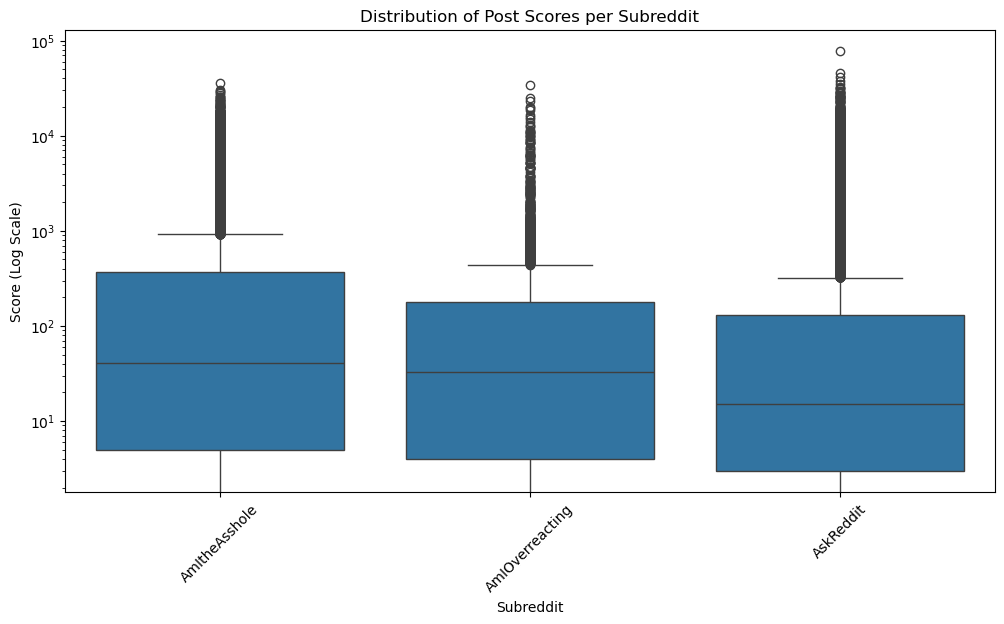

In [51]:
# Convert to Pandas for plotting if necessary
posts_df_pd = posts_df.select("subreddit_post", "score_post").toPandas()

plt.figure(figsize=(12, 6))
sns.boxplot(data=posts_df_pd, x="subreddit_post", y="score_post")
plt.yscale('log')  # Optional: use logarithmic scale if there are outliers or wide ranges
plt.title('Distribution of Post Scores per Subreddit')
plt.xlabel('Subreddit')
plt.ylabel('Score (Log Scale)')
plt.xticks(rotation=45)
plt.show()

In [52]:
top_authors = posts_df.filter(F.col("viral") == 1).groupBy("post_author").agg(
    F.count("*").alias("num_viral_posts")
).orderBy(F.desc("num_viral_posts")).limit(10)

top_authors.show()

+-------------------+---------------+
|        post_author|num_viral_posts|
+-------------------+---------------+
|          [deleted]|             93|
|        FlintTheDad|             13|
|    ThisIsExxciting|              9|
|        youngGod928|              7|
|Amazing-Living-9957|              6|
|     AlgorithmOmega|              6|
|            Jerswar|              6|
|       PhillyBigboy|              5|
|           theary18|              5|
|       Casca_In_Red|              5|
+-------------------+---------------+



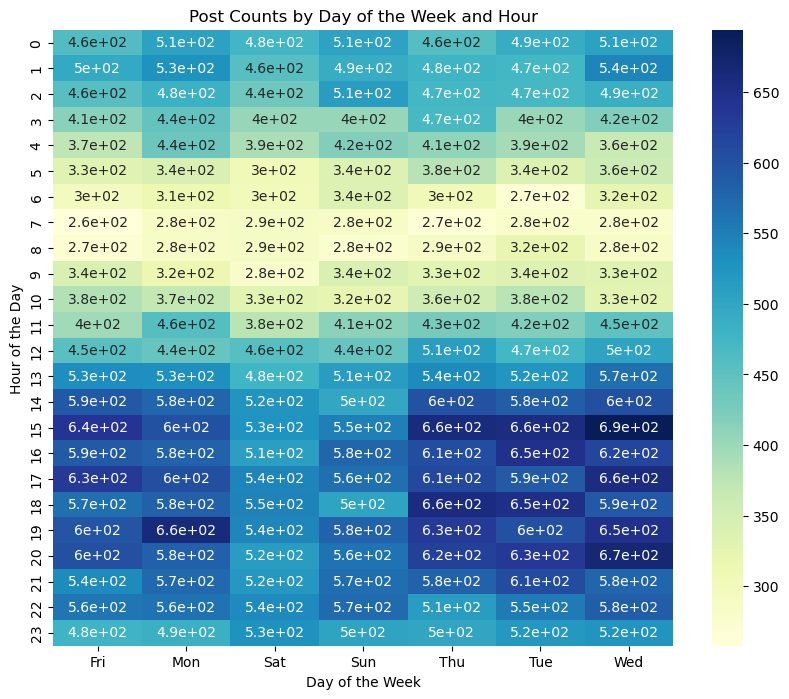

In [55]:
# Convert to Pandas for easier heatmap plotting
post_counts_pd = post_counts.toPandas().pivot(index="hour", columns="day_of_week", values="count")

# Plotting
plt.figure(figsize=(10, 8))
sns.heatmap(post_counts_pd, cmap="YlGnBu", annot=True)
plt.title('Post Counts by Day of the Week and Hour')
plt.xlabel('Day of the Week')
plt.ylabel('Hour of the Day')
plt.show()

In [54]:
nsfw_stats = posts_df.groupBy("subreddit_post").agg(
    F.count("*").alias("total_posts"),
    F.sum(F.when(F.col("over_18") == True, 1).otherwise(0)).alias("nsfw_posts")
).withColumn(
    "nsfw_percentage",
    (F.col("nsfw_posts") / F.col("total_posts")) * 100
)

nsfw_stats.select("subreddit_post", "total_posts", "nsfw_posts", "nsfw_percentage").show()

+---------------+-----------+----------+------------------+
| subreddit_post|total_posts|nsfw_posts|   nsfw_percentage|
+---------------+-----------+----------+------------------+
|  AmItheAsshole|      33836|       235|0.6945265397801158|
|AmIOverreacting|       3470|       202| 5.821325648414986|
|      AskReddit|      42296|      5536|13.088708152071119|
+---------------+-----------+----------+------------------+



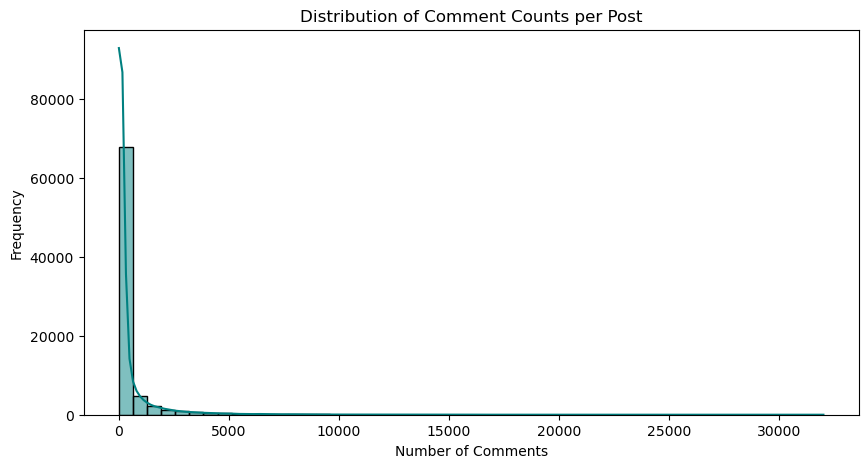

In [56]:
# Convert to Pandas
comment_counts_pd = posts_df.select("num_comments").toPandas()

# Plotting
plt.figure(figsize=(10, 5))
sns.histplot(comment_counts_pd["num_comments"], bins=50, kde=True, color="teal")
plt.title('Distribution of Comment Counts per Post')
plt.xlabel('Number of Comments')
plt.ylabel('Frequency')
plt.show()

In [61]:
from pyspark.sql.functions import explode, split, lower

# Tokenize and count words in titles
word_counts = posts_df.withColumn("word", explode(split(lower(F.col("post_title")), "\\s+"))).groupBy(
    "subreddit_post", "word"
).count().orderBy(F.desc("count"))

# Filter out common stop words (optional)
stop_words = set(["a", "the", "for", "and", "of", "is", "to", "in", "it", "with", "on", "at", "by", "you", "my", "what", "your", "aio", "do", "not", "i", "that", "me", "telling", "are", " ", "about"])  # Add more as needed
word_counts = word_counts.filter(~F.col("word").isin(stop_words))

# Get top 5 words per subreddit
top_words = word_counts.groupBy("subreddit_post").agg(
    F.collect_list(F.struct("count", "word")).alias("words")
).select("subreddit_post", F.expr("slice(words, 1, 5)").alias("top_words"))

# Convert to Pandas for display
top_words_pd = top_words.toPandas()
print(top_words_pd)

    subreddit_post                                          top_words
0        AskReddit  [(5182, would), (4927, what's), (4568, if), (3...
1    AmItheAsshole  [(29368, aita), (3901, her), (2678, if), (2646...
2  AmIOverreacting  [(833, ), (413, boyfriend), (379, am), (341, h...


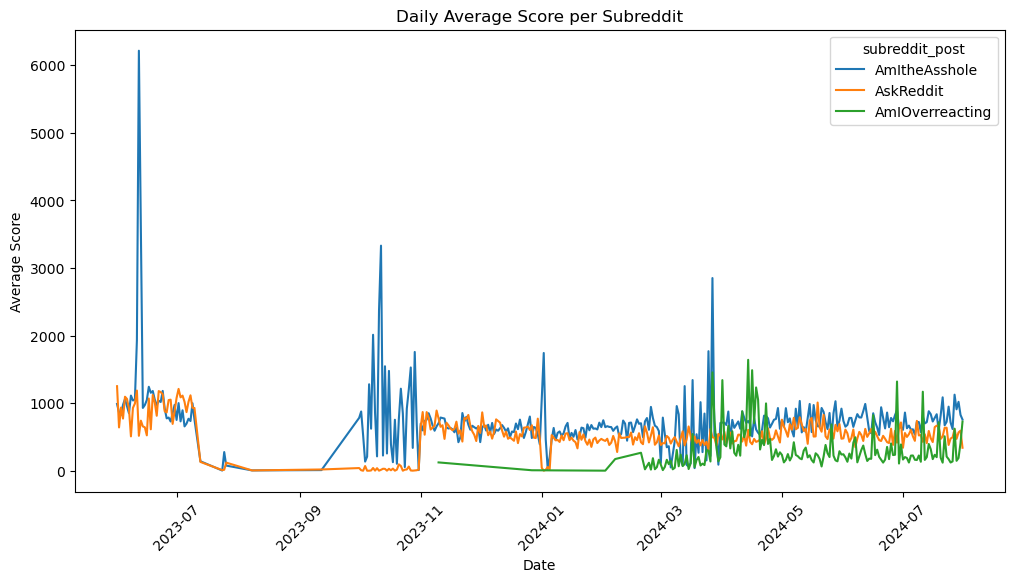

In [62]:
# Calculate daily average score per subreddit
daily_avg_score = posts_df.groupBy("subreddit_post", F.to_date("created_date_post").alias("date")).agg(
    F.avg("score_post").alias("avg_score")
).orderBy("date")

# Convert to Pandas
daily_avg_score_pd = daily_avg_score.toPandas()

# Plotting
plt.figure(figsize=(12, 6))
sns.lineplot(data=daily_avg_score_pd, x="date", y="avg_score", hue="subreddit_post")
plt.title('Daily Average Score per Subreddit')
plt.xlabel('Date')
plt.ylabel('Average Score')
plt.xticks(rotation=45)
plt.show()